# Project description

Project name: Customer churn prediction

Project tasks: Conduct an exploratory analysis, build a predictive churn model to identify and retain customers through special offers.

# Data download

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report, plot_confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

import lightgbm
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from tensorflow import keras

#from hyperopt import fmin, tpe, hp, space_eval

In [2]:
contract = pd.read_csv('contract.csv')
internet = pd.read_csv('internet.csv')
personal = pd.read_csv('personal.csv')
phone = pd.read_csv('phone.csv')

All required data downloaded.

# Preprocessing

In [3]:
contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


There are no gaps in the downloaded dataset. I will change the formats of some columns, in particular BeginDate (to date), TotalCharges (to float64). 

In [5]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

In [6]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = 0
#Заменил пропуски на 0, что бы можно было перевести во float
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

In [7]:
contract['target'] = contract['EndDate'].apply(lambda x: 0 if x=='No' else 1)

In [8]:
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [11]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [12]:
phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [13]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


There are no gaps in the last three tables, the formats are correct. 

For convenience, I will make CustomerID an index.

In [14]:
contract = contract.set_index('customerID')
personal = personal.set_index('customerID')
phone = phone.set_index('customerID')
internet = internet.set_index('customerID')

Joining datasets.

In [15]:
telecom = contract.join([internet, personal, phone])

In [16]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   target            7043 non-null   int64         
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovie

As you can see, many lines are left empty, this is due to the fact that some customers use only one service. I'll fill in the blanks.

In [17]:
telecom = telecom.fillna('NoData')

I will add a couple of features that will be useful for exploratory analysis.

I'll start with the total number of months of using the services.

In [18]:
telecom['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [19]:
telecom['EndDate2'] = telecom['EndDate'].apply(lambda x: '2020-02-01' if x=='No' else x) #информация актуальна на 2 февраля 2020
telecom['EndDate2'] = pd.to_datetime(telecom['EndDate2'])
telecom['TotalMonths'] = round((telecom['EndDate2'] - telecom['BeginDate'])/np.timedelta64(1, 'M'), 0)
telecom = telecom.drop(['EndDate2'], axis=1)

Now I will group the data by MonthlyCharges.

In [20]:
telecom['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [21]:
def monthly_charges_group (x):
    if x <= 20:
        return 1
    elif x <= 40:
        return 2
    elif x <= 60:
        return 3
    elif x <= 80:
        return 4
    elif x <= 100:
        return 5
    else:
        return 6

In [22]:
telecom['MCH_group'] = telecom['MonthlyCharges'].apply(monthly_charges_group)

In [23]:
telecom['MCH_group'].value_counts()

5    1764
4    1459
2    1182
3    1080
6     902
1     656
Name: MCH_group, dtype: int64

Now TotalCharges

In [24]:
telecom['TotalCharges'].describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

In [25]:
def total_charges_group (x):
    if x <= 400:
        return 1
    elif 400 <= x <= 1400:
        return 2
    elif 1400 <= x <= 3800:
        return 3
    else:
        return 4

In [26]:
telecom['TCH_group'] = telecom['TotalCharges'].apply(total_charges_group)

I also group users by the number of connected additional services.

In [27]:
def services_amount_group (row):
    count = 0
    if row['InternetService'] != 'No' and row['InternetService'] != 'NoData':
        count += 1
    if row['OnlineSecurity'] == 'Yes':
        count += 1
    if row['OnlineBackup'] == 'Yes':
        count += 1
    if row['DeviceProtection'] == 'Yes':
        count += 1
    if row['TechSupport'] == 'Yes':
        count += 1
    if row['StreamingTV'] == 'Yes':
        count += 1
    if row['StreamingMovies'] == 'Yes':
        count += 1
    if row['MultipleLines'] == 'Yes':
        count += 1
    return count

In [28]:
telecom['SA_group'] = telecom.apply(services_amount_group, axis=1).astype('float64')

In [29]:
telecom['SA_group'].value_counts()

0.0    1184
4.0     978
3.0     957
5.0     933
1.0     825
2.0     816
6.0     722
7.0     420
8.0     208
Name: SA_group, dtype: int64

# Exploratory data analysis

First, let's take a closer look at the customers who left.

In [30]:
len(contract.query('EndDate != "No"'))/7043

0.2653698707936959

26.5% of the dataset are former clients. I will add a target column where 1 client left 0 no.

In [31]:
telecom_leavers = telecom.query('target == 1')

In [32]:
telecom_leavers.head(15)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,InternetService,OnlineSecurity,...,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,TotalMonths,MCH_group,TCH_group,SA_group
customerID,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,DSL,Yes,...,No,Male,0,No,No,No,2.0,3,1,3.0
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Fiber optic,No,...,No,Female,0,No,No,No,2.0,4,1,1.0
9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,1,Fiber optic,No,...,Yes,Female,0,No,No,Yes,8.0,5,2,5.0
7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,1,Fiber optic,No,...,Yes,Female,0,Yes,No,Yes,28.0,6,3,6.0
0280-XJGEX,2015-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,Fiber optic,No,...,Yes,Male,0,No,No,Yes,49.0,6,4,6.0
4190-MFLUW,2019-01-01,2019-11-01 00:00:00,Month-to-month,No,Credit card (automatic),55.20,528.35,1,DSL,No,...,No,Female,0,Yes,Yes,No,10.0,3,2,3.0
8779-QRDMV,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,39.65,39.65,1,DSL,No,...,Yes,Male,1,No,No,NoData,1.0,2,1,3.0
1066-JKSGK,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,20.15,20.15,1,NoData,NoData,...,NoData,Male,0,No,No,No,1.0,2,1,0.0
6467-CHFZW,2015-12-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.35,4749.15,1,Fiber optic,No,...,Yes,Male,0,Yes,Yes,Yes,47.0,5,4,5.0


So nothing immediately catches your eye, in addition to the fact that all withdrawn clients had monthly payments. Which is quite logical, since most likely the client who has entered into a long-term contract is satisfied with the services provided.

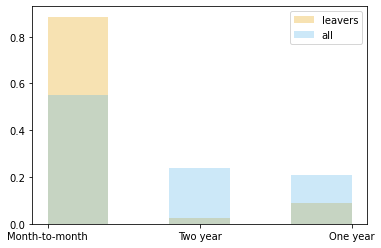

In [33]:
leavers = telecom_leavers['Type']
all = telecom['Type']

pyplot.hist(leavers, bins = 5, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
pyplot.hist(all, bins =5, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
pyplot.legend(loc='upper right')
pyplot.show()

In [34]:
len(telecom_leavers.query('Type == "Month-to-month"'))/len(telecom_leavers)

0.8855002675227395

In [35]:
len(telecom.query('Type == "Month-to-month"'))/len(telecom)

0.5501916796819537

The hypothesis was confirmed among former clients, the share of monthly contracts is 33% higher.

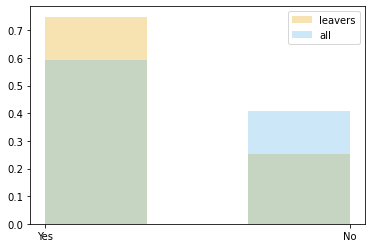

In [36]:
leavers = telecom_leavers['PaperlessBilling']
all = telecom['PaperlessBilling']

pyplot.hist(leavers, bins = 3, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
pyplot.hist(all, bins =3, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
pyplot.legend(loc='upper right')
pyplot.show()

In [37]:
len(telecom.query('PaperlessBilling != "No"'))/len(telecom)

0.5922192247621753

In [38]:
len(telecom_leavers.query('PaperlessBilling != "No"'))/len(telecom_leavers)

0.7490636704119851

Here the dependence is not as pronounced as in the Type column. However, users with PaperlessBilling are 15% more likely to opt out of services.

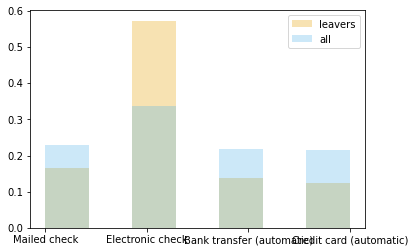

In [39]:
leavers = telecom_leavers['PaymentMethod']
all = telecom['PaymentMethod']

pyplot.hist(leavers, bins = 7, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
pyplot.hist(all, bins =7, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
pyplot.legend(loc='upper right')
pyplot.show()

In [40]:
len(telecom_leavers.query('PaymentMethod == "Electronic check"'))/len(telecom_leavers)

0.5730337078651685

In [41]:
len(telecom.query('PaymentMethod == "Electronic check"'))/len(telecom)

0.3357944057929859

Among the customers who left, 57% (24% more then among all users) were those who had an Electronic check payment method.

In [42]:
telecom_leavers['InternetService'].value_counts()

Fiber optic    1297
DSL             459
NoData          113
Name: InternetService, dtype: int64

In [43]:
telecom['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
NoData         1526
Name: InternetService, dtype: int64

In [44]:
contract['target'] = contract['EndDate'].apply(lambda x: 0 if x=='No' else 1)

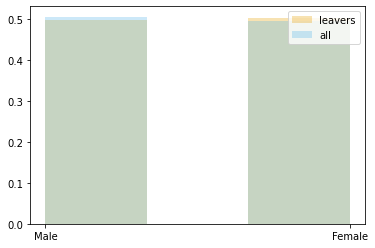

In [45]:
leavers = telecom_leavers['gender']
all = telecom['gender']

pyplot.hist(leavers, bins = 3, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
pyplot.hist(all, bins =3, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
pyplot.legend(loc='upper right')
pyplot.show()

There is practically no dependence on gender. Let's check the impact of having a pension certificate.

In [46]:
telecom['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

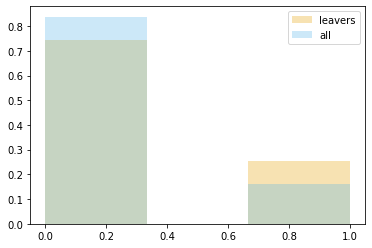

In [47]:
leavers = telecom_leavers['SeniorCitizen']
all = telecom['SeniorCitizen']

pyplot.hist(leavers, bins = 3, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
pyplot.hist(all, bins =3, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
pyplot.legend(loc='upper right')
pyplot.show()

In [48]:
len(telecom_leavers.query('SeniorCitizen == 1'))/len(telecom_leavers) - len(telecom.query('SeniorCitizen == 1'))/len(telecom)

0.09253483550219332

Pensioners are 9% more likely to refuse company services. Let's check the effect of loneliness.

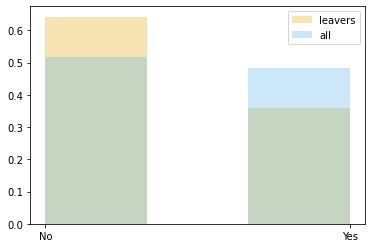

In [49]:
leavers = telecom_leavers['Partner']
all = telecom['Partner']

pyplot.hist(leavers, bins = 3, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
pyplot.hist(all, bins =3, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
pyplot.legend(loc='upper right')
pyplot.show()

In [50]:
len(telecom_leavers.query('Partner == "No"'))/len(telecom_leavers) - len(telecom.query('Partner == "No"'))/len(telecom)

0.12508737316220087

Lonely people are 12.5% more likely to refuse company services. Let's check the impact of having dependents.

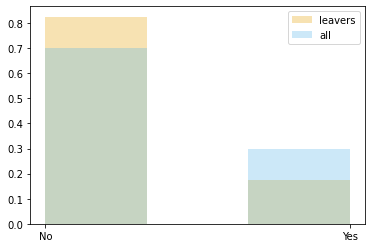

In [51]:
leavers = telecom_leavers['Dependents']
all = telecom['Dependents']

pyplot.hist(leavers, bins = 3, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
pyplot.hist(all, bins =3, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
pyplot.legend(loc='upper right')
pyplot.show()

In [52]:
len(telecom_leavers.query('Dependents == "No"'))/len(telecom_leavers) - len(telecom.query('Dependents == "No"'))/len(telecom)

0.12516341753595417

Clients without dependents were 12.5% more likely to refuse the company's services. Same result.

According to the personal table, we can conclude that single childless pensioners are the most risky group of clients. It is also worth looking after those who pay the tariff monthly and by means of electronic checks.

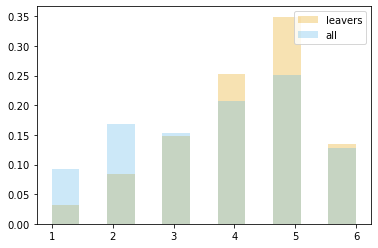

In [53]:
leavers = telecom_leavers['MCH_group']
all = telecom['MCH_group']

pyplot.hist(leavers, bins = 11, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
pyplot.hist(all, bins = 11, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
pyplot.legend(loc='upper right')
pyplot.show()

Those customers who paid more were more likely to refuse services. Quite logical.

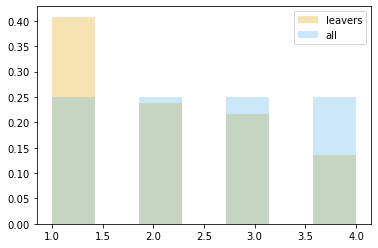

In [54]:
leavers = telecom_leavers['TCH_group']
all = telecom['TCH_group']

pyplot.hist(leavers, bins = 7, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
pyplot.hist(all, bins = 7, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
pyplot.legend(loc='upper right')
pyplot.show()

In [55]:
len(telecom_leavers.query('TCH_group == 1'))/len(telecom_leavers) - len(telecom.query('TCH_group == 1'))/len(telecom)

0.15749427938915628

Clients from the first group are 15.7% more likely to refuse services, which is also logical since they probably use the company's services not so long ago, therefore they have low total_charges values. However, such a conclusion gives us not the most visual information on both monthly and total charges. Perhaps we will display another graph that better displays the distribution.

C:\conda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\conda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


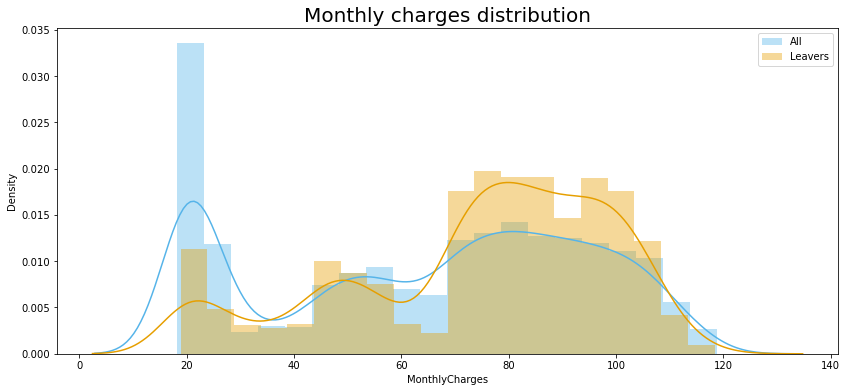

In [56]:
pyplot.figure(figsize = (14, 6))
sns.distplot(telecom['MonthlyCharges'], label='All', bins=20, color = '#56B4E9')
sns.distplot(telecom_leavers['MonthlyCharges'], label='Leavers', bins=20, color = '#E69F00')
pyplot.title('Monthly charges distribution', fontsize=20)
pyplot.legend();

In [57]:
len(telecom.query('MonthlyCharges > 60'))/7043

0.5856879170807895

In [58]:
telecom['MonthlyCharges'].mean()

64.76169246059922

In [59]:
telecom_leavers['MonthlyCharges'].mean()

74.4413322632423

As expected, the lower the customer's monthly payment, the less likely they are to leave. Most of those who left paid more than 60 per month.

C:\conda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\conda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


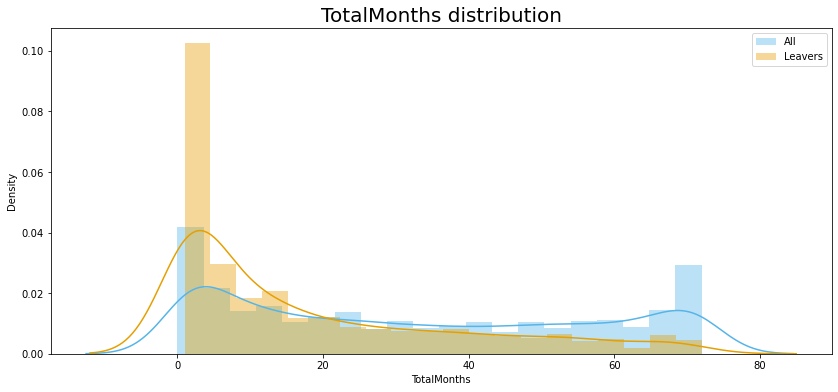

In [60]:
pyplot.figure(figsize = (14, 6))
sns.distplot(telecom['TotalMonths'], label='All', bins=20, color = '#56B4E9')
sns.distplot(telecom_leavers['TotalMonths'], label='Leavers', bins=20, color = '#E69F00')
pyplot.title('TotalMonths distribution', fontsize=20)
pyplot.legend();

As expected, the less time the client uses the services, the higher the likelihood that he will leave.

In [61]:
len(telecom_leavers.query('TotalMonths < 20'))/len(telecom_leavers)

0.6597110754414125

Nearly 66% of lost users have been connected to their accounts for less than 20 months

In [62]:
len(telecom_leavers.query('TotalMonths < 2'))/len(telecom_leavers)

0.20331728196896737

20% of lost users were connected to services for less than 2 months

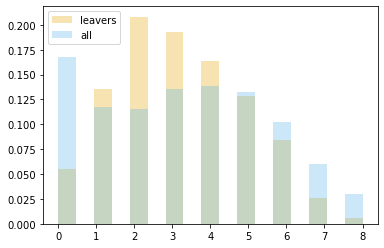

In [63]:
leavers = telecom_leavers['SA_group']
all = telecom['SA_group']

pyplot.hist(leavers, bins = 17, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
pyplot.hist(all, bins = 17, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
pyplot.legend(loc='upper left')
pyplot.show()

It is difficult to draw a conclusion on the ratio of former customers to the number of connected services without considering specific connected services.

I think it is worth considering the Internet and mobile communications separately. Let's start with mobile communications. there are fewer services available.

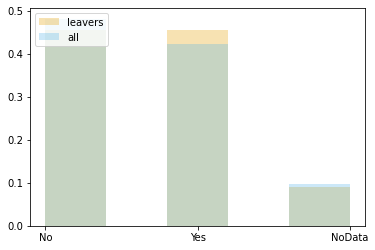

In [64]:
leavers = telecom_leavers['MultipleLines']
all = telecom['MultipleLines']

pyplot.hist(leavers, bins = 5, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
pyplot.hist(all, bins = 5, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
pyplot.legend(loc='upper left')
pyplot.show()

There is no pronounced dependence; we turn to the Internet.

In [65]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 473.9+ KB


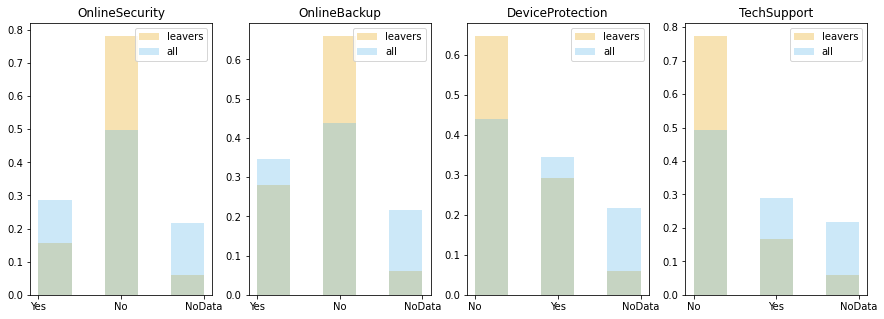

In [66]:
fig, ax = pyplot.subplots(1, 4, figsize=(15, 5))
column = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
x = 0
for i in column:
    leavers = telecom_leavers[i]
    all = telecom[i]

    ax[x].hist(leavers, bins = 5, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
    ax[x].hist(all, bins = 5, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
    ax[x].legend(loc='upper right')
    ax[x].set_title(i)
    x += 1

pyplot.show()

Dependence is noticeable in the derived services. The presence of these services, with the Internet connected, reduces the likelihood of a client leaving.

In [67]:
print(len(telecom_leavers.query('OnlineSecurity =="No"'))/len(telecom_leavers) - len(telecom.query('OnlineSecurity =="No"'))/len(telecom))
print(len(telecom_leavers.query('OnlineBackup =="No"'))/len(telecom_leavers) - len(telecom.query('OnlineBackup =="No"'))/len(telecom))
print(len(telecom_leavers.query('DeviceProtection =="No"'))/len(telecom_leavers) - len(telecom.query('DeviceProtection =="No"'))/len(telecom))
print(len(telecom_leavers.query('TechSupport =="No"'))/len(telecom_leavers) - len(telecom.query('TechSupport =="No"'))/len(telecom))

0.2850380909382835
0.22126155109099366
0.2084966559087808
0.2805620324951815


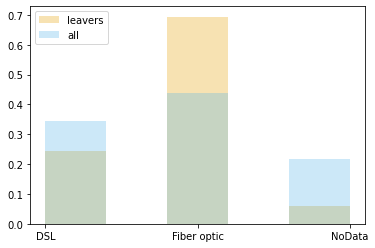

In [68]:
leavers = telecom_leavers['InternetService']
all = telecom['InternetService']

pyplot.hist(leavers, bins = 5, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
pyplot.hist(all, bins = 5, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
pyplot.legend(loc='upper left')
pyplot.show()

People with Fiber optic service are more likely to refuse services. Something is probably wrong with the Fiber optic.

In [69]:
print(len(telecom_leavers.query('InternetService =="Fiber optic"'))/len(telecom_leavers) - len(telecom.query('InternetService =="Fiber optic"'))/len(telecom))

0.25436858214163593


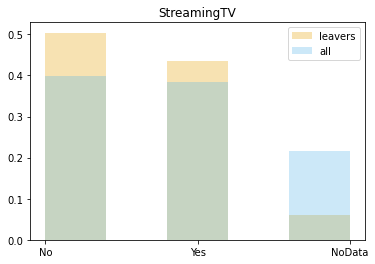

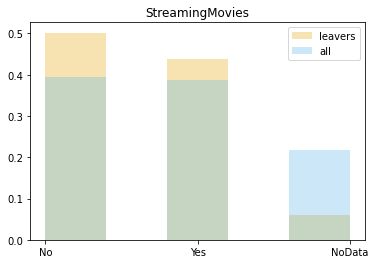

In [70]:
column = ['StreamingTV', 'StreamingMovies']
for i in column:
    leavers = telecom_leavers[i]
    all = telecom[i]

    pyplot.hist(leavers, bins = 5, alpha=0.3, label='leavers',color = '#E69F00', weights=np.ones(len(telecom_leavers)) / len(telecom_leavers))
    pyplot.hist(all, bins = 5, alpha=0.3, label='all',color = '#56B4E9', weights=np.ones(len(telecom)) / len(telecom))
    pyplot.legend(loc='upper right')
    pyplot.title(i)
    pyplot.show()

It is difficult to talk about the impact of StreamingTV and StreamingMovies services on the likelihood of a customer leaving. However, in general, according to the internet table or the last 7 histograms, specifically for NoData (clients who did not connect to the Internet), it can be concluded that the company's customers who did not connect to the Internet are less likely to refuse services.

To confirm the hypothesis, it is worth highlighting groups of customers by connected services.

In [71]:
def user_type (row):
    internet_user = row['InternetService']
    phone_user = row['MultipleLines']
    if (internet_user == 'Fiber optic' or internet_user == 'DSL') and (phone_user=='No' or phone_user=='Yes'):
        return 'Internet and phone'
    elif (internet_user == 'Fiber optic' or internet_user == 'DSL') and phone_user == 'NoData':
        return 'Internet only'
    elif phone_user=='No' or phone_user=='Yes' and internet_user == 'NoData':
        return 'Phone only'
    else:
        return 'Unknown'

In [72]:
telecom['UserType'] = telecom.apply(user_type, axis=1)

In [73]:
pie_user_type_all = telecom['UserType'].value_counts()

Let's split the table again.

In [74]:
telecom_leavers = telecom.query('target == 1')

In [75]:
pie_user_type_leavers = telecom_leavers['UserType'].value_counts()

Text(0.5, 0.98, 'User type')

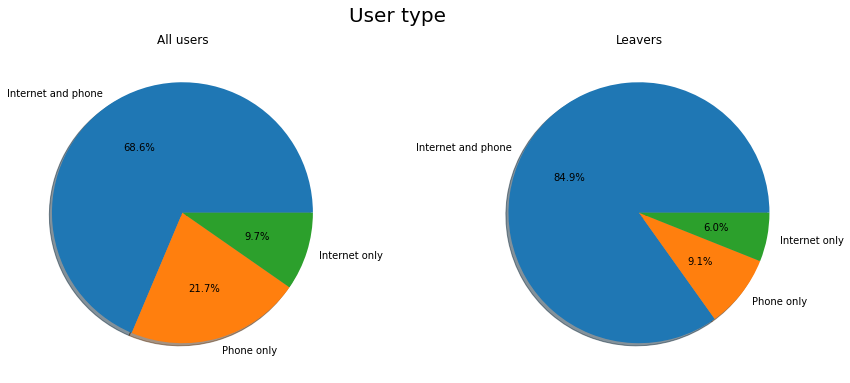

In [76]:
fig, ax = pyplot.subplots(1, 2, figsize=(15, 6))
ax[0].pie(pie_user_type_all, labels = pie_user_type_all.index, autopct='%1.1f%%', shadow=True)
ax[0].set_title('All users')
ax[1].pie(pie_user_type_leavers, labels = pie_user_type_all.index, autopct='%1.1f%%', shadow=True)
ax[1].set_title('Leavers')
fig.suptitle('User type', fontsize=20)

The hypothesis was confirmed. Among customers who refused services, there are much fewer Phone only users. There are also noticeably more users who use both the Internet and mobile communications among those who refused services.

In [77]:
quantitive_columns = ['SA_group','TotalMonths', 'MonthlyCharges', 'TotalCharges', 'UserType']
pyplot.figure(figsize=(10, 8))
telecom[quantitive_columns].corr()

,SA_group,TotalMonths,MonthlyCharges,TotalCharges
SA_group,1.000000,0.473866,0.821725,0.763796
TotalMonths,0.473866,1.000000,0.247900,0.826178
MonthlyCharges,0.821725,0.247900,1.000000,0.651174
TotalCharges,0.763796,0.826178,0.651174,1.000000


<Figure size 720x576 with 0 Axes>

0.826178 TotalMonths dependency on TotalCharges, remove TotalCharges

In [78]:
telecom = telecom.drop('TotalCharges', axis=1)

# EA Conclusions

1) 88% of former users made a 'Month-to-month' contact. Only 55% Month-to-month contracts across the entire dataset.

2) Users with connected PaperlessBilling are 15% more likely to refuse services.

3) Among the customers who left, there are 24% more of those who had an Electronic check payment method, compared to the entire sample.

4) Pensioners are 9% more likely to refuse company services.

5) Lonely or just childless people are 12.5% more likely to refuse company services.

6) 58% of those who left paid more than 60 per month. The average monthly payment for the entire dataset is 64, and for those who left 74.

7) Nearly 66% of lost users have been connected to their accounts for less than 20 months. 20% of lost users were connected to services for less than 2 months

8) The client's lack of 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport' services increases the probability of a client leaving by 29, 22, 20, 28%, respectively. These services can be offered to clients who are on the list of potential exits.

9) People with the Fiber optic service refuse services more often. Something is probably wrong with the Fiber optic.

10) The total share of users who use both the Internet and the phone is 69%, while in the former customers this share is 85%.

# Data preparation for models

In [79]:
telecom_coded = telecom

In [80]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   target            7043 non-null   int64         
 7   InternetService   7043 non-null   object        
 8   OnlineSecurity    7043 non-null   object        
 9   OnlineBackup      7043 non-null   object        
 10  DeviceProtection  7043 non-null   object        
 11  TechSupport       7043 non-null   object        
 12  StreamingTV       7043 non-null   object        
 13  StreamingMovies   7043 non-null   object        
 14  gender        

Recode categorical features.

In [81]:
columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
           'TechSupport', 'StreamingTV', 
           'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'UserType']
for i in columns:
    telecom_coded[i] = telecom_coded[i].astype('category')
cat_columns = telecom_coded.select_dtypes(['category']).columns
telecom_coded[cat_columns] = telecom_coded[cat_columns].apply(lambda x: x.cat.codes)

In [82]:
telecom_coded

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,target,InternetService,OnlineSecurity,OnlineBackup,...,gender,SeniorCitizen,Partner,Dependents,MultipleLines,TotalMonths,MCH_group,TCH_group,SA_group,UserType
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,0,1,2,29.85,0,0,0,2,...,0,0,1,0,1,1.0,2,1,2.0,1
5575-GNVDE,2017-04-01,No,1,0,3,56.95,0,0,2,0,...,1,0,0,0,0,34.0,3,3,3.0,0
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,0,1,3,53.85,1,0,2,2,...,1,0,0,0,0,2.0,3,1,3.0,0
7795-CFOCW,2016-05-01,No,1,0,0,42.30,0,0,2,0,...,1,0,0,0,1,45.0,3,3,4.0,1
9237-HQITU,2019-09-01,2019-11-01 00:00:00,0,1,2,70.70,1,1,0,0,...,0,0,0,0,0,2.0,4,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,1,1,3,84.80,0,0,2,0,...,1,0,1,1,2,24.0,5,3,7.0,0
2234-XADUH,2014-02-01,No,1,1,1,103.20,0,1,0,2,...,0,0,1,1,2,72.0,6,4,6.0,0
4801-JZAZL,2019-03-01,No,0,1,2,29.60,0,0,2,0,...,0,0,1,1,1,11.0,2,1,2.0,1


I need to remove the EndDate and BeginDate leaks, otherwise it will be too easy for the model to find those who left.

In [83]:
telecom_coded = telecom_coded.drop(['EndDate'], axis=1)
telecom_coded = telecom_coded.drop(['BeginDate'], axis=1)

In [84]:
train, test = train_test_split(telecom_coded, shuffle=False, test_size=0.2)

In [85]:
train_telecom_feature = train.drop('target', axis=1)
train_telecom_target = train['target']
test_telecom_feature = test.drop('target', axis=1)
test_telecom_target = test['target']

In [86]:
telecom_coded

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,target,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,gender,SeniorCitizen,Partner,Dependents,MultipleLines,TotalMonths,MCH_group,TCH_group,SA_group,UserType
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,2,29.85,0,0,0,2,0,0,...,0,0,1,0,1,1.0,2,1,2.0,1
5575-GNVDE,1,0,3,56.95,0,0,2,0,2,0,...,1,0,0,0,0,34.0,3,3,3.0,0
3668-QPYBK,0,1,3,53.85,1,0,2,2,0,0,...,1,0,0,0,0,2.0,3,1,3.0,0
7795-CFOCW,1,0,0,42.30,0,0,2,0,2,2,...,1,0,0,0,1,45.0,3,3,4.0,1
9237-HQITU,0,1,2,70.70,1,1,0,0,0,0,...,0,0,0,0,0,2.0,4,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,1,1,3,84.80,0,0,2,0,2,2,...,1,0,1,1,2,24.0,5,3,7.0,0
2234-XADUH,1,1,1,103.20,0,1,0,2,2,0,...,0,0,1,1,2,72.0,6,4,6.0,0
4801-JZAZL,0,1,2,29.60,0,0,2,0,0,0,...,0,0,1,1,1,11.0,2,1,2.0,1


# RandomForestClassifier

In [87]:
%%time
#tscv = TimeSeriesSplit()
clf = RandomForestClassifier()
parametrs = {'n_estimators': range (31, 41, 2), 'max_depth': range (41, 51, 2)}
grid = GridSearchCV(clf, parametrs, cv=5, scoring='roc_auc', n_jobs = -1)
grid.fit(train_telecom_feature, train_telecom_target)
grid.best_params_

Wall time: 6.69 s


{'max_depth': 47, 'n_estimators': 37}

In [88]:
%%time
model = RandomForestClassifier(**grid.best_params_, random_state=12345)
model.fit(train_telecom_feature, train_telecom_target)
predictions = model.predict(test_telecom_feature)
RFCauc = round(roc_auc_score(test_telecom_target, model.predict_proba(test_telecom_feature)[:, 1]), 3)
RFCacc = accuracy_score(test_telecom_target, predictions)
print('auc_roc_score',RFCauc)
print('accuracy',RFCacc)

auc_roc_score 0.809
accuracy 0.7899219304471257
Wall time: 234 ms


# XGBClassifier

In [89]:
%%time
#tscv = TimeSeriesSplit()
clf = xgboost.XGBClassifier()
parametrs = {'n_estimators': range (19, 29, 1), 'max_depth': range (1, 11, 1), 'min_child_weight':range(13, 21,1)}
grid = GridSearchCV(clf, parametrs, cv=5, scoring='roc_auc', n_jobs = -1)
grid.fit(train_telecom_feature, train_telecom_target)
grid.best_params_

[20:06:59] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1min 40s


C:\conda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'max_depth': 3, 'min_child_weight': 16, 'n_estimators': 21}

In [90]:
%%time
model = xgboost.XGBClassifier(**grid.best_params_, random_state=12345)
model.fit(train_telecom_feature, train_telecom_target)
predictions = model.predict(test_telecom_feature)
XGBauc = roc_auc_score(test_telecom_target, model.predict_proba(test_telecom_feature)[:, 1])
XGBacc = accuracy_score(test_telecom_target, predictions)
print('auc_roc_score',XGBauc)
print('accuracy',XGBacc)

[20:07:00] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
auc_roc_score 0.8462537148809707
accuracy 0.7977288857345636
Wall time: 50.2 ms


# LGBMClassifier

In [91]:
%%time
#tscv = TimeSeriesSplit()
clf = lightgbm.LGBMClassifier()
parametrs = {'n_estimators': range (50, 60, 1), 'max_depth': range (6, 16, 1), 'min_child_weight':range(46,56,1)}
grid = GridSearchCV(clf, parametrs, cv=3, scoring='roc_auc', n_jobs = -1)
grid.fit(train_telecom_feature, train_telecom_target)
grid.best_params_

Wall time: 1min 8s


{'max_depth': 8, 'min_child_weight': 49, 'n_estimators': 51}

In [92]:
%%time
model = lightgbm.LGBMClassifier(**grid.best_params_, random_state=12345)
model.fit(train_telecom_feature, train_telecom_target)
predictions = model.predict(test_telecom_feature)
LGBMauc = roc_auc_score(test_telecom_target, model.predict_proba(test_telecom_feature)[:, 1])
LGBMacc = accuracy_score(test_telecom_target, predictions)
print('auc_roc_score',LGBMauc)
print('accuracy',LGBMacc)

auc_roc_score 0.8516307178528754
accuracy 0.7998580553584103
Wall time: 55 ms


# Model conclusions

In [93]:
results = pd.DataFrame({'Model' : ['RandomForestClassifier', 'XGBClassifier', 'LGBMClassifier'], 'roc_auc score' : [RFCauc, XGBauc, LGBMauc], 'accuracy score' : [RFCacc, XGBacc, LGBMacc]})
results

,Model,roc_auc score,accuracy score
0,RandomForestClassifier,0.809000,0.789922
1,XGBClassifier,0.846254,0.797729
2,LGBMClassifier,0.851631,0.799858


The best value of roc_auc (0.8517813556379382) on the considered parameters was achieved using the LGBMClassifier model. There is a model that accurately determines the outgoing customers. Recommendations for customer retention are noted in the IA findings.